### **ANN Streamflow Prediction**

*_Author: Aline Van Driessche_*

This notebook contains all code needed to reproduce the ANN training results on individual catchments (meteorological inputs available from Era5 and groundtruth streamflow from the NRFA). Read section headings for more details on setup, preprocessing, and model training.

#### Setup

Importing relevant modules and custom scripts. A number of helper functions are also defined to clean up experiment code.

In [164]:
import os
import paths
import random
import torch
import warnings

import utils as ut
import numpy as np
import pandas as pd
import datetime as dt
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdt
import matplotlib.ticker as mtk

from tqdm import tqdm
from shapely import Point
from matplotlib import gridspec
from apollo import osgconv as osg
from apollo import metrics as me
from apollo import mechanics as ma
from apollo import streamflow as strf
from train_model import load_data, train

warnings.filterwarnings('ignore')

In [161]:
def find_longest_diagonal(polygon):
    box = polygon.minimum_rotated_rectangle
    x, y = box.exterior.coords.xy

    # get length of bounding box edges
    edge_length = (Point(x[0], y[0]).distance(Point(x[1], y[1])), Point(x[1], y[1]).distance(Point(x[2], y[2])))
    return max(edge_length)

In [162]:
def calculate_latitude(geometry):
    
    points = geometry.centroid
    lat, lon = osg.BNG_2_latlon(points.x, points.y)
    return lat 

In [163]:
def calculate_slope_gradient(gdf, metadata):

    gdf['Cross_distance'] = gdf['Geometry'].apply(lambda geometry: find_longest_diagonal(geometry)) 
    gdf['Area']= gdf['Geometry'].apply(lambda geometry: geometry.area)
    
    gdf['Minimum altitude'] = gdf['Station'].apply(lambda station: metadata[metadata['Station number'] == int(station)]['Minimum altitude'].iloc[0])
    gdf['Maximum altitude'] = gdf['Station'].apply(lambda station: metadata[metadata['Station number'] == int(station)]['Maximum altitude'].iloc[0])
    gdf['Height difference'] = gdf['Maximum altitude'] - gdf['Minimum altitude']
    gdf['Slope gradient'] = gdf['Height difference']/gdf['Cross_distance']
    return gdf

### Experiment Variables

All variables that could be modified during the experiments. The features refer to the type of input variables that will be used for training and how many days in the past are included.

In [2]:
station = 54057

days = 6
features = (['Rain'] + ['Rain-' + f'{d+1}' for d in range(days)] 
            + ['Temperature'] + ['Temperature-' + f'{d+1}' for d in range(days)] \
            + ['Resultant Windspeed'] + ['Resultant Windspeed-' + f'{d+1}' for d in range(days)] \
            + ['Humidity'] + ['Humidity-' + f'{d+1}' for d in range(days)]\
            + ['Rain_28_Mu','Rain_90_Mu','Rain_180_Mu', 'Temperature_28_Mu','Temperature_90_Mu','Temperature_180_Mu']) 

years_train = [1980 + i for i in range(30)]
years_eval = [2010 + i for i in range(10)]

input_type = '9to9_linear' #others: {'linear', '9to9_cubic', '9to9_surf_interp' ...}

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Loading and Processing Relevant Data

Data loading function that extracts and preprocesses the data as defined in the “Experiment Variables” section and returns the in- and output for training. The initial catchment information (shapefile catchment boundary etc) are downloaded from the *https://nrfa.ceh.ac.uk/* website. For reproduction, also the river streamflow can be obtained from the *https://nrfa.ceh.ac.uk/* website, and the meteorological input variables through the Coopernicus CDS API, *https://cds.climate.copernicus.eu/*. The input variables are preprocessed in the correct manner after running 'assembly.py'. 

In [3]:
# General information
general_info_df = pd.read_csv('../' + paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '_gdf.csv'))
catchment_boundary = gpd.read_file('../' + paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '.shp'))

In [4]:
# In- and output variables
original_data = pd.read_csv('../' + paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + f"_lumped_{input_type}.csv"))
original_data['Date'] = pd.to_datetime(original_data['Date'], format='%Y-%m-%d').dt.date
clean_data = original_data.dropna(subset=['Flow'])
print(len(original_data) - len(clean_data), 'riverflow values are missing.')

123 riverflow values are missing.


#### Running Experiments

Data is extracted and preprocessed as defined in the "Experiment Variables" section. We use a neural network training using the hyperparameters as described above. The paper outlines which metrics generate the best performances for each latitude. Our three metrics (RMSE, NSE, RE) are then calculated.

In [18]:
def train_NN(rf, years_train, years_eval, features=features, loss_func=None, alpha=1.0, beta=1.0, grid_search=False, early_stopping=True, verbose=True):

    # LOAD DATA
    trnset, full_set = load_data.preprocess_data(rf, features, years_eval, years_train)
    targets = ['Flow']
    xspace = ma.featurelocator(rf, features)
    yspace = ma.featurelocator(rf, targets)

    x_train = load_data.reshape_input(trnset, xspace)
    y_train = load_data.reshape_output(trnset, yspace)   
    
    psi = ut.psi_distribution(y_train, 'lognorm', alpha=alpha, beta=beta, plot=verbose)
    
    # TRAINING
    network = train.train(x_train, 
                          y_train,
                          verbose=verbose, 
                          loss_func_type=loss_func, 
                          psi=psi[:len(x_train)], 
                          grid_search=grid_search, 
                          early_stopping=early_stopping)

    # EVALUATION
    x_eval = load_data.reshape_input(full_set, xspace)  
    y_eval = load_data.reshape_input(full_set, yspace)  
    
    rf.loc[:, 'Predicted'] = network.predict(torch.from_numpy(x_eval).to(device))
    rf.loc[:, 'Groundtruth'] = y_eval    
    rf['Date'] =  pd.to_datetime(rf['Date'], unit='s')
    rf = rf[rf['Date'].dt.year.isin(years_train + years_eval)]
    rf.reset_index(drop=True, inplace=True)
    return rf

#### Experiment 1

Run the standard NN on a single catchment and calculate the performance.

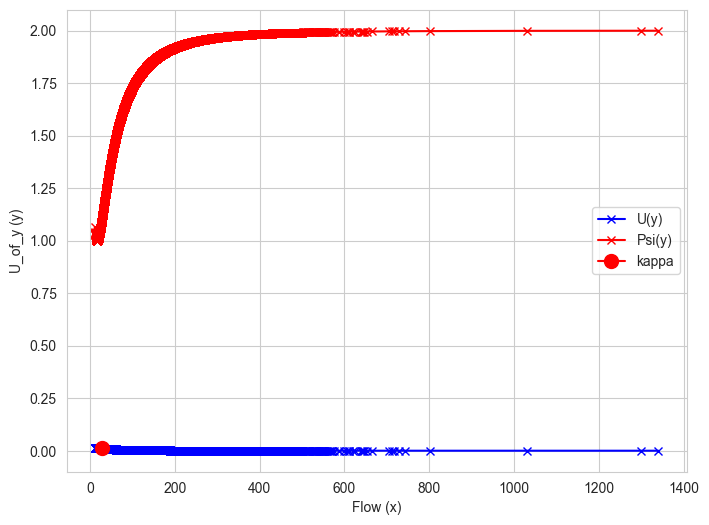

epoch 0, loss 24054.568359375
epoch 500, loss 4779.13037109375
epoch 1000, loss 2763.04345703125
epoch 1500, loss 2490.967529296875
epoch 2000, loss 2348.686279296875
epoch 2500, loss 2232.30126953125
epoch 3000, loss 2107.180908203125
epoch 3500, loss 1980.494140625
epoch 4000, loss 1848.5814208984375
epoch 4500, loss 1701.1121826171875
epoch 5000, loss 1533.7930908203125
epoch 5500, loss 1391.4984130859375
epoch 6000, loss 1268.2691650390625
Early stopping at epoch 6470, best validation loss: 2060.767822265625


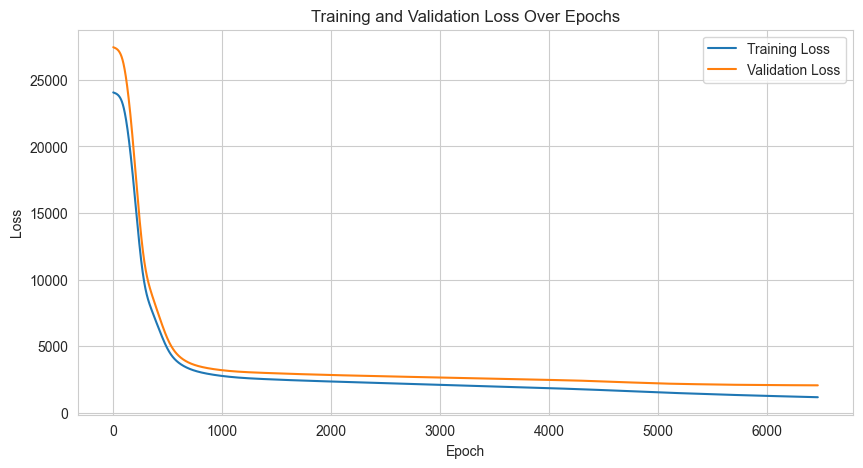

In [19]:
outdf = train_NN(rf=clean_data.copy(), years_train=years_train, years_eval=years_eval, features=features, loss_func=None,alpha=1, beta=2, grid_search=False,verbose=True) 

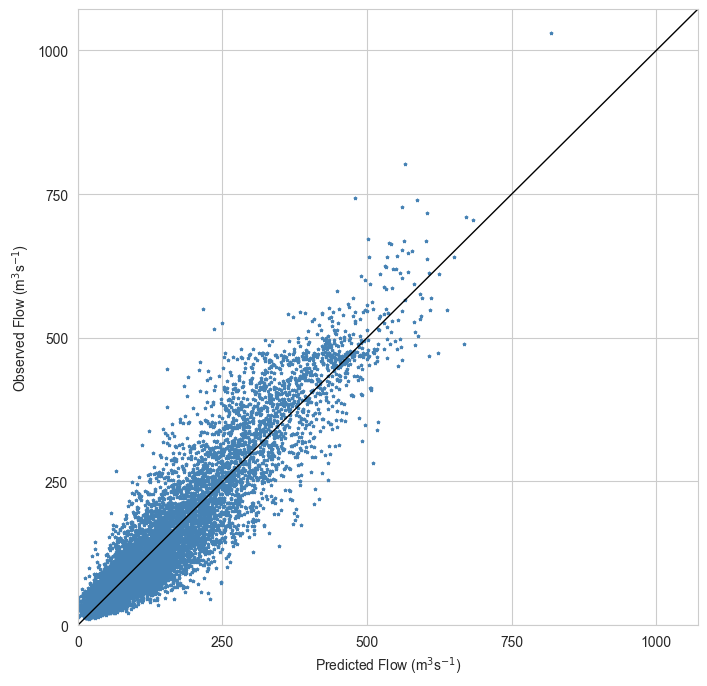

RMSE: 39.475421541553864
NSE: 0.8783101791244732
RE: 0.9197290662883832


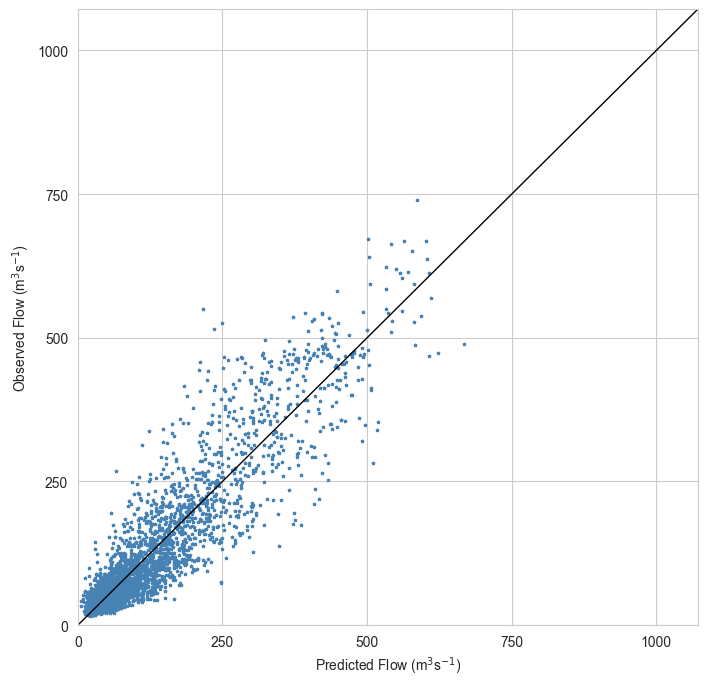

RMSE: 46.85625485073316
NSE: 0.8421252775639695
RE: 0.9254654270739101


In [466]:
# Plot the network performance
for test_period in (years_train+years_eval, years_eval):
     
    performance_dict = train.calculate_performance_metrics(outdf, test_period) 

    print('RMSE: ' + str(performance_dict.get('RMSE')))
    print('NSE: ' + str(performance_dict.get('NSE')))
    print('RE: ' + str(performance_dict.get('RE')))

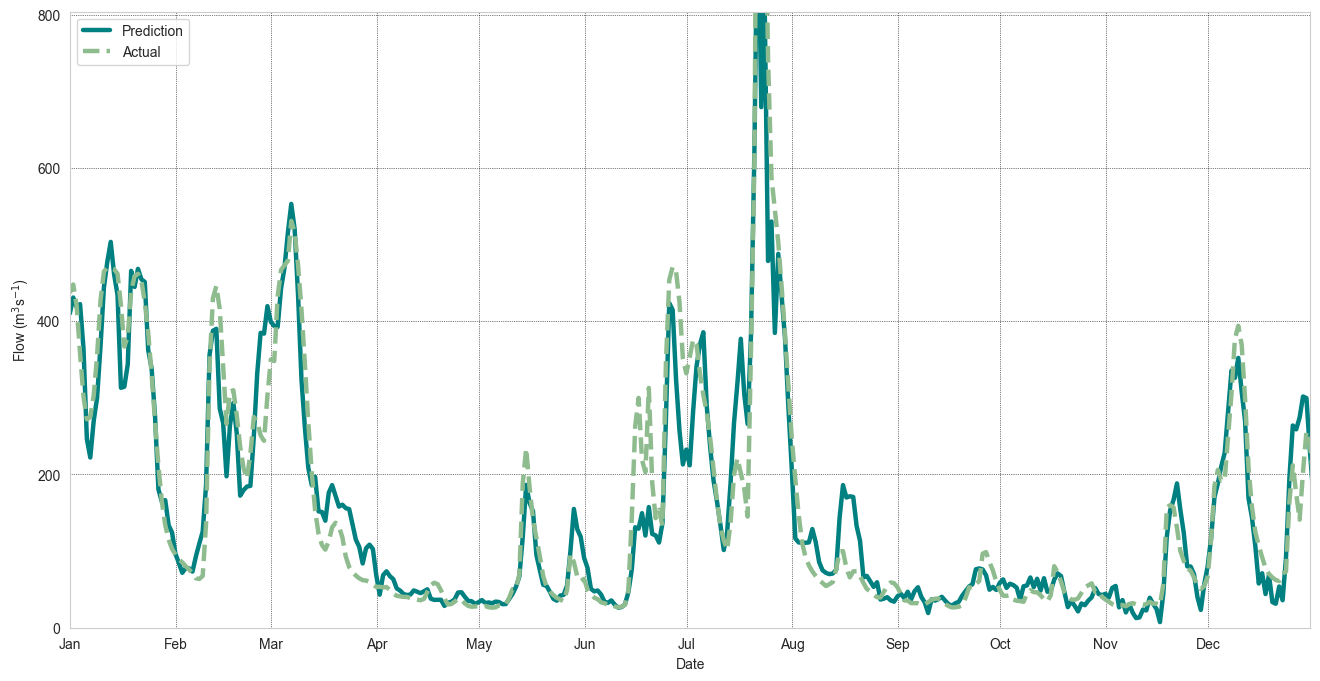

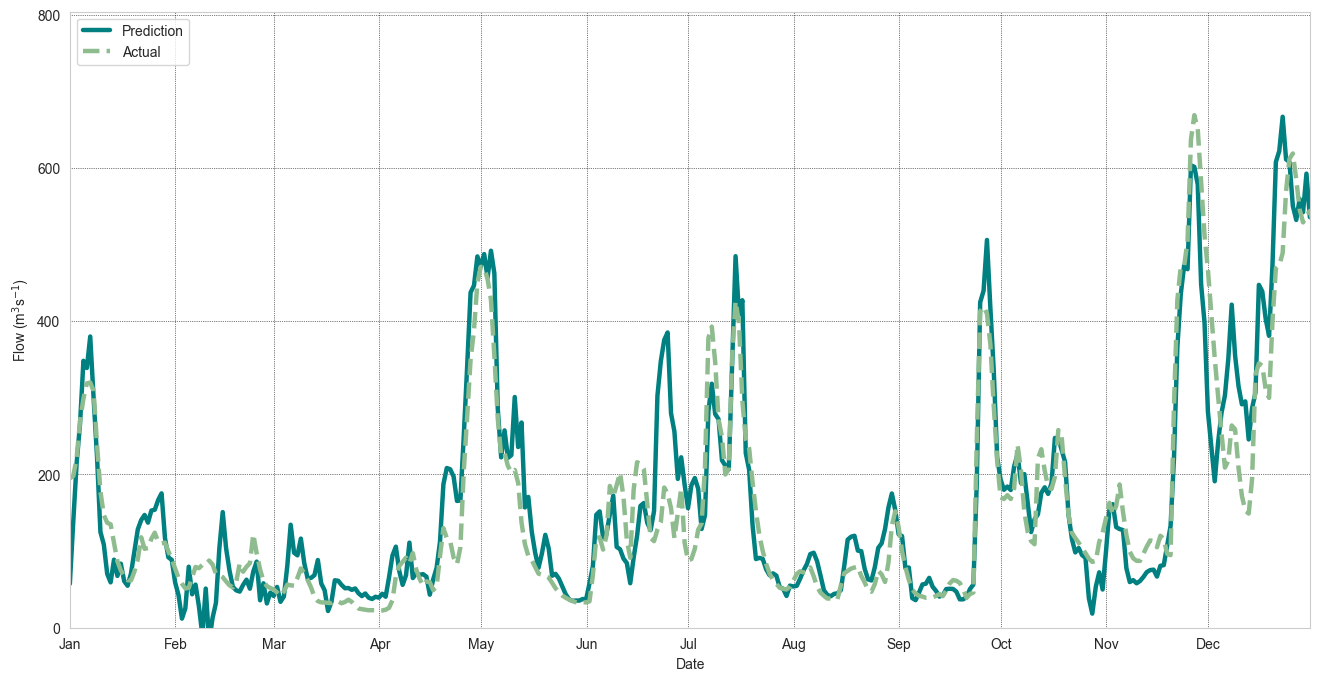

In [467]:
# Plot the visual performance for selected years
strf.year_plot(outdf, 'Predicted', 'Flow', 2007)
strf.year_plot(outdf, 'Predicted', 'Flow', 2012) 

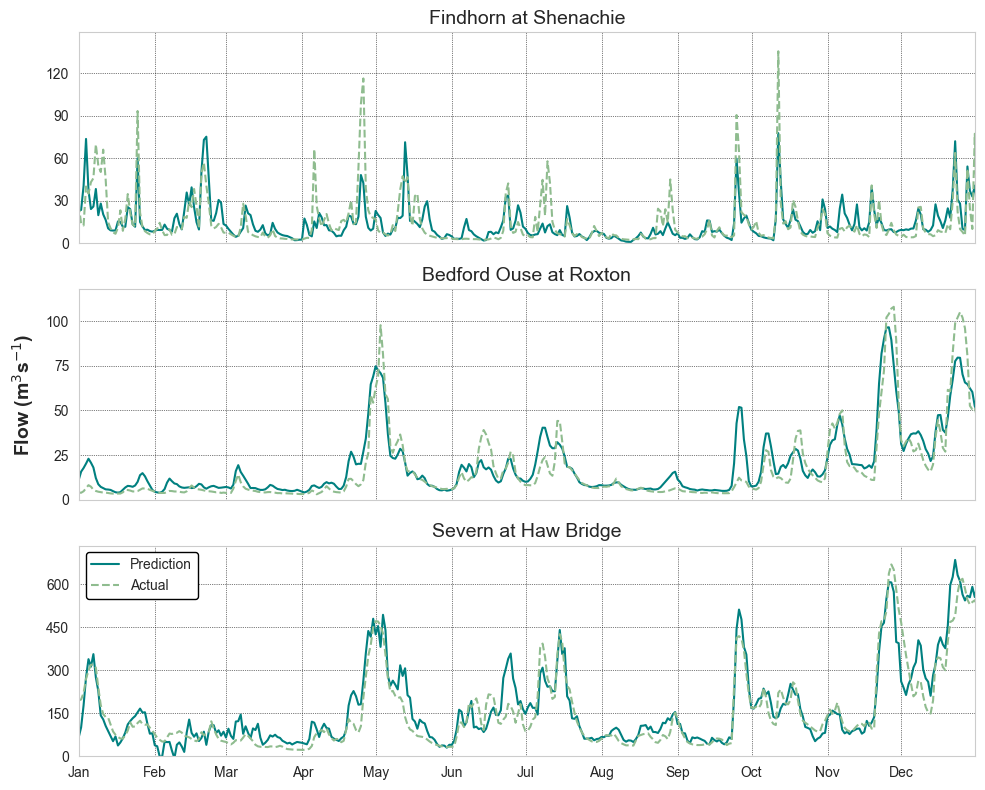

In [445]:
# PLOT performance for 1 year across the 3 most important sites
stations = ['7001', '33039', '54057']
titles = ['Findhorn at Shenachie', 'Bedford Ouse at Roxton', 'Severn at Haw Bridge']

fig, ax = plt.subplots(len(stations), figsize=(10, 8), sharex=True)

colour1 = 'Teal'
colour2 = 'darkseagreen'

year = 2012

for i, station in enumerate(stations):
    
    catchment_boundary = gpd.read_file('../' + paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(station) + '.shp')
    
    original_data = pd.read_csv('../' + paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(station) + f"_lumped_{input_type}.csv")
    original_data['Date'] = pd.to_datetime(original_data['Date'], format='%Y-%m-%d').dt.date
    clean_data = original_data.dropna(subset=['Flow'])
    
    outdf = train_NN(rf=clean_data.copy(), years_train=years_train, years_eval=years_eval, features=features, loss_func=None, alpha=1, beta=2, grid_search=False, verbose=False)
    
    maxflow = int(1.1 * max(np.array(outdf[outdf['Date'].dt.year.isin([year])]['Groundtruth'])))
    
    ax[i].plot(outdf['Date'], outdf['Predicted'], colour1, lw=1.5, label='Prediction')
    ax[i].plot(outdf['Date'], outdf['Groundtruth'], colour2, lw=1.5, ls='--', label='Actual')
    
    ax[i].set_xlim([dt.date(year, 1, 1), dt.date(year, 12, 31)])
    ax[i].set_ylim(0, maxflow)
    ax[i].grid(c='black', ls='dotted', lw=0.5)
    ax[i].margins(x=0, y=0)

    if i == len(stations) - 1:
        ax[i].legend(loc='upper left', edgecolor='black', framealpha=1)

    ax[i].set_title(titles[i], size=14)
    ax[i].xaxis.set_major_locator(mdt.MonthLocator())
    ax[i].xaxis.set_major_formatter(mdt.DateFormatter('%b'))
    ax[i].yaxis.set_major_locator(mtk.MaxNLocator(5))

# Labeling the y-axis
fig.supylabel('Flow (m' + r'$^3$' + 's' + r'$^{-1}$' + ')', weight='bold', size=14)

# Spacing
plt.tight_layout()
plt.savefig(f'{paths.IMAGES}/stacked_riverflow_performances.png', dpi=300, bbox_inches='tight')
plt.show()

#### Experiment 2

Calculate the mean performance metrics on the 3 individual catchments based on a k-fold cross-validation. Training is similar as before, except that the training/test split is carried out randomly instead of based on fixed (chronological) periods of time.

In [468]:
total_years = [1980 + i for i in range(40)]
k_folds = 5

In [469]:
performance_metrics = []
for i in tqdm(range(k_folds), desc="K-Fold Progress"):
    
    years_eval = random.sample(total_years, 10)
    years_train = [year for year in total_years if year not in years_eval]
    
    outdf = train_NN(rf=clean_data.copy(), years_train=years_train, years_eval=years_eval, features=features, loss_func=None,alpha=1, beta=2, grid_search=False,verbose=False) 
    
    performance_dict = train.calculate_performance_metrics(outdf, years_eval, plot=False) 
    performance_metrics.append(performance_dict)
    
performance_df = pd.DataFrame(performance_metrics)
mean_performance = performance_df.mean()
mean_performance

K-Fold Progress: 100%|██████████| 5/5 [06:03<00:00, 72.67s/it]


RMSE    49.215488
NSE      0.816639
RE       0.925629
dtype: float64

#### Experiment 3

Expand across 25 other UK catchments. The descriptions for all these catchments are defined in 'Catchment_Database.csv', where station number, station name, flow file, boundary file ... are defined per catchment. All this information has been retrieved from the *https://nrfa.ceh.ac.uk/* website. The model predictions are stored for each catchment individually. Based on these performances, the NSE for each catchment is calculated, as a comparative metric. Other catchment characteristics (hydrological efficiency, slope gradient, latitude ..) are deduced from the previously obtained data (flow & geographical boundaries) from NRFA. These characteristics are then used to plot the correlation with the model performance in each catchment.

In [166]:
## MODEL TRAINING + PREDICTIONS

for station_nr in tqdm(os.listdir('../' + paths.CATCHMENT_BASINS), desc="Processing Stations"):
    
    out_path = '../' + paths.PREDICTIONS + f"/{input_type}/{station_nr}_{input_type}.csv"
    
    if not os.path.exists(out_path):
        catchment_boundary = gpd.read_file('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(station_nr) + '.shp')
    
        original_data = pd.read_csv('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(station_nr) + f"_lumped_{input_type}.csv")
        original_data['Date'] = pd.to_datetime(original_data['Date'], format='%Y-%m-%d').dt.date
        clean_data = original_data.dropna(subset=['Flow'])
    
        outdf = train_NN(rf=clean_data, years_train=years_train, years_eval=years_eval, features=features, loss_func=None, alpha=1, beta=2, grid_search=False, verbose=False)
        outdf.to_csv(out_path)

Processing Stations: 100%|██████████| 26/26 [00:00<00:00, 25804.99it/s]


In [169]:
## MODEL PERFORMANCE

new_data_list = []
for station_nr in os.listdir('../' + paths.CATCHMENT_BASINS):
    
    df = pd.read_csv('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_gdf.csv'))
    name = df.loc[df.index[3]].iloc[2]
    
    boundary = gpd.read_file('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '.shp'))
    
    df_predictions = pd.read_csv('../' + paths.PREDICTIONS + f"/{input_type}/{station_nr}_{input_type}.csv")
    df_predictions = df_predictions.loc[:, ~df_predictions.columns.str.contains('^Unnamed')]
    df_predictions['Date'] = pd.to_datetime(df_predictions['Date'], format='%Y-%m-%d %H:%M:%S').dt.normalize()
    
    df_test = df_predictions[df_predictions['Date'].dt.year.isin(years_eval)]
    NSE = me.R2(df_test['Flow'], df_test['Predicted'])
    HE_mean = (df_test['Flow'].mean()/boundary.geometry.area)*((10^6))*86400000
    
    new_data_list.append({
        'Station': station_nr,
        'Name': name,
        'NSE': NSE,
        'HE_mean': HE_mean,
        'Geometry': boundary.geometry.iloc[0]
    })

overview_gdf = gpd.GeoDataFrame(new_data_list)

metadata = pd.read_csv('../' + paths.DATA + '/Catchments_Fens.csv')
overview_gdf = calculate_slope_gradient(overview_gdf, metadata)
overview_gdf['Latitude'] = overview_gdf['Geometry'].apply(lambda geometry: calculate_latitude(geometry))

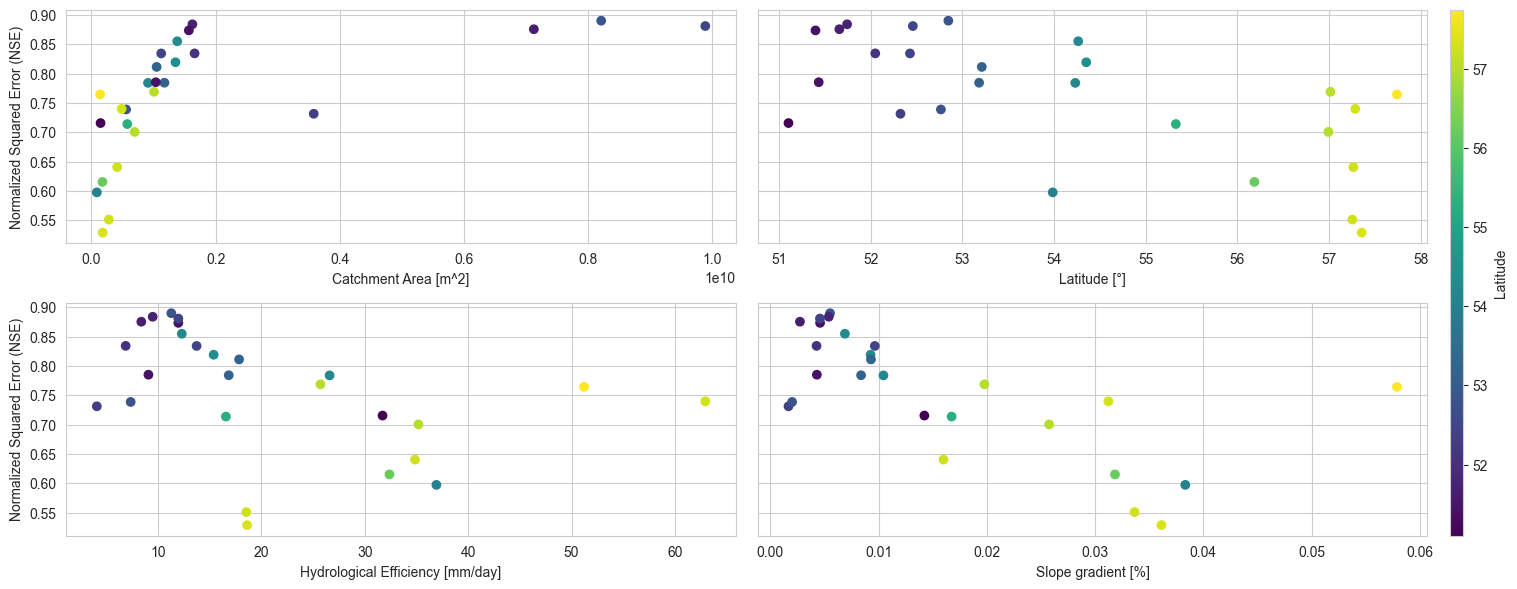

In [170]:
## PERFORMANCE PLOT

params_to_plot = ['Area', 'Latitude', 'HE_mean', 'Slope gradient']
labels_to_plot = ['Catchment Area [m^2]', 'Latitude [°]', 'Hydrological Efficiency [mm/day]', 'Slope gradient [%]']

fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.02])
axes = [fig.add_subplot(gs[i // 2, i % 2]) for i in range(4)]

cmap = plt.get_cmap('viridis')
norm = plt.Normalize(overview_gdf['Latitude'].min(), overview_gdf['Latitude'].max())

# Plot each parameter in its respective subplot
for i, param in enumerate(params_to_plot):
    if i < 4:
        sc = axes[i].scatter(overview_gdf[param], overview_gdf['NSE'], c=overview_gdf['Latitude'], cmap=cmap, norm=norm, marker='o')
        axes[i].set_xlabel(labels_to_plot[i])
        if i == 0 or i == 2:
            axes[i].set_ylabel('Normalized Squared Error (NSE)')
        else:
            axes[i].set_yticklabels([])
        
        # Add station names next to each dot
        #for j, row in overview_gdf.iterrows():
            #axes[i].text(row[param], row['NSE'], row['Station'], fontsize=8, ha='left')
        
        axes[i].grid(True)

# Add colorbar to indicate latitude
cax = fig.add_subplot(gs[:, 2]) 
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cax, orientation='vertical', label='Latitude')

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.savefig(f"{paths.IMAGES}/cross_catchments_comparison.png", dpi=300, bbox_inches='tight')
plt.show()